In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=64ddf66c5d339076a2e9a09779086bca6e8c71d8b8629bd2840743ccff580000
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.functions import expr


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/04 09:52:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# read csv:
df = spark.read.csv('/kaggle/input/big-data/PS_20174392719_1491204439457_log.csv', inferSchema=True, header=True)

In [4]:
df.createOrReplaceTempView('temp_table')

### 1. Types of Transactions:

In [5]:
result = spark.sql('select type, count(1) from temp_table group by type')

In [6]:
result.show()

+--------+--------+
|    type|count(1)|
+--------+--------+
|TRANSFER|  532909|
| CASH_IN| 1399284|
|CASH_OUT| 2237500|
| PAYMENT| 2151495|
|   DEBIT|   41432|
+--------+--------+



In [7]:
result = result.toPandas()

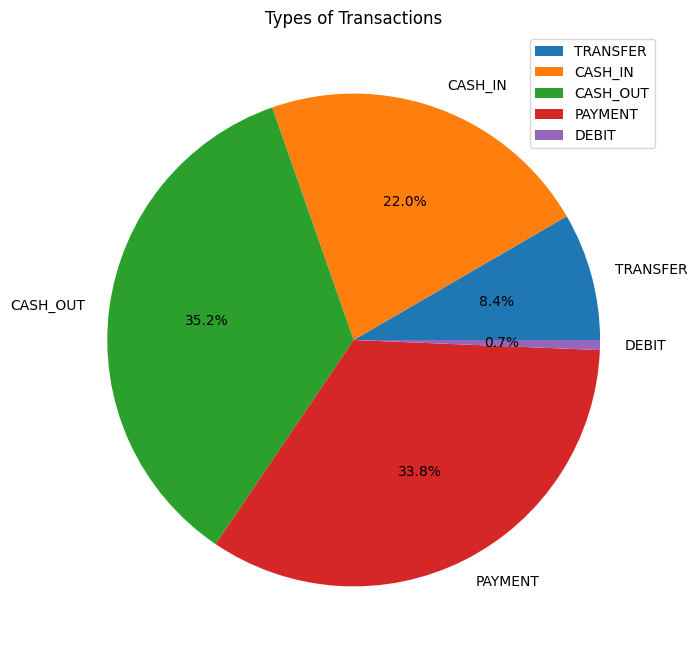

In [8]:
plt.figure(figsize = (8,8))
plt.pie(result['count(1)'], labels = result['type'], autopct='%1.1f%%')
plt.legend()
plt.title('Types of Transactions')
plt.show()

In [9]:
result1 = spark.sql('select type, sum(amount) from temp_table group by type')

In [10]:
result1 = result1.toPandas()

In [11]:
result1.head()

,type,sum(amount)
0,TRANSFER,4.852920e+11
1,CASH_IN,2.363674e+11
2,CASH_OUT,3.944130e+11
3,PAYMENT,2.809337e+10
4,DEBIT,2.271992e+08


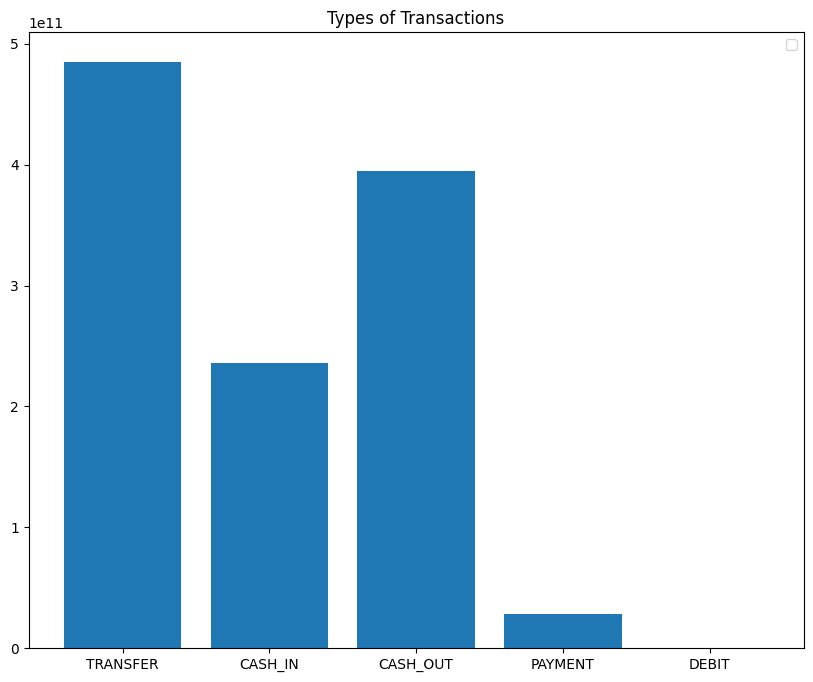

In [12]:
plt.figure(figsize = (10,8))
plt.bar(result1['type'], result1['sum(amount)'])
plt.legend()
plt.title('Types of Transactions')
plt.show()

### 2. Transactions and Total Amounts with Fraud:

In [13]:
result2 = spark.sql('select isFraud, count(*) as count from temp_table group by isFraud')

In [14]:
result2.show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   8213|
|      0|6354407|
+-------+-------+



In [15]:
result2 = result2.toPandas()

In [16]:
result2['isFraud'] = result2['isFraud'].replace({0: 'Non-fraud', 1: 'Fraud'})

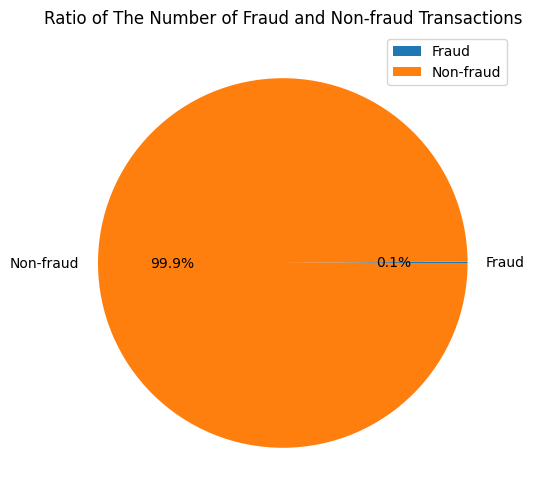

In [17]:
plt.figure(figsize = (6,6))
plt.pie(result2['count'], labels = result2['isFraud'], autopct='%1.1f%%')
plt.legend()
plt.title('Ratio of The Number of Fraud and Non-fraud Transactions')
plt.show()

### 3. Balance Difference with Fraud:

In [18]:
df = df.withColumn("balanceDifference", expr("oldbalanceOrg - newbalanceOrig"))

In [19]:
df.createOrReplaceTempView('temp_table')

In [20]:
df.show()

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+------------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud| balanceDifference|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+------------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0| 9839.640000000014|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|1864.2799999999988|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|             181.0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0| 

In [21]:
result3 = spark.sql("SELECT balanceDifference, isFraud FROM temp_table")

In [22]:
result3 = result3.toPandas()

/tmp/ipykernel_18/2898975338.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(result3.loc[result3['isFraud'] == 1, 'balanceDifference'], label='Fraud', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_18/2898975338.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(result3.loc[result3['isFraud'] == 0, 'balanceDifference'], label='Non_fraud', shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

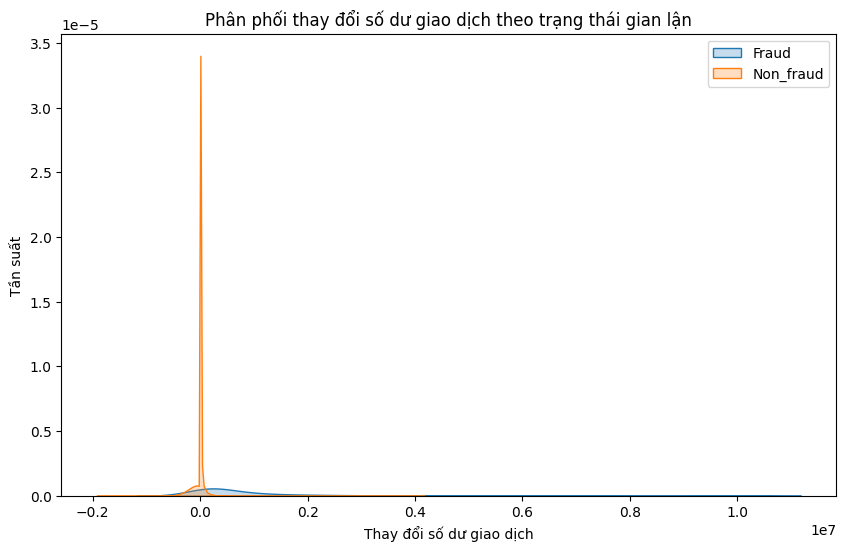

In [23]:
# Vẽ biểu đồ KDE Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(result3.loc[result3['isFraud'] == 1, 'balanceDifference'], label='Fraud', shade=True)
sns.kdeplot(result3.loc[result3['isFraud'] == 0, 'balanceDifference'], label='Non_fraud', shade=True)
plt.title('Phân phối thay đổi số dư giao dịch theo trạng thái gian lận')
plt.xlabel('Thay đổi số dư giao dịch')
plt.ylabel('Tần suất')
plt.legend()
plt.show()

In [24]:
df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)
 |-- balanceDifference: double (nullable = true)

